In [1]:
import pandas as pd
import json
import gzip
# sudo pip install pandas


In [2]:
def feature_engineeer_mean(df):
    columns_to_average = ['dwelling_time_neg_1', 'dwelling_time_0', 'dwelling_time_1', 
                      'mean_neg_1', 'mean_0', 'mean_1', 
                      'sd_neg_1', 'sd_0', 'sd_1']

    # Group by 'transcript_id' and 'gene_id' and calculate the mean for each column
    averaged_df = df.groupby(['transcript_id', 'transcript_position']).agg({
        'dwelling_time_neg_1': ['mean', 'min', 'max', 'median'],
        'dwelling_time_0': ['mean', 'min', 'max', 'median'],
        'dwelling_time_1': ['mean', 'min', 'max', 'median'],
        'mean_neg_1': ['mean', 'min', 'max', 'median'],
        'mean_0': ['mean', 'min', 'max', 'median'],
        'mean_1': ['mean', 'min', 'max', 'median'],
        'sd_neg_1': ['mean', 'min', 'max', 'median'],
        'sd_0': ['mean', 'min', 'max', 'median'],
        'sd_1': ['mean', 'min', 'max', 'median'],
    }).reset_index()

    # Rename columns to desired format
    averaged_df.columns = [
        f'{col[0]}_{col[1]}' if col[1] != '' else col[0]  # Join column names with '_'
        for col in averaged_df.columns
    ]

    return averaged_df

# averaged_df = feature_engineeer_mean(df)

In [21]:
# get number of reads for each transcript

def feature_engineer_read_count(df):
    df['read_count'] = df.groupby([ 'transcript_id'])['transcript_id'].transform('count')
    return df

# averaged_df = feature_engineer_read_count(averaged_df)

### Normalise

In [26]:
from sklearn.preprocessing import StandardScaler

def normalise(df):
    # Initialize the scaler
    scaler = StandardScaler()

    excluded_columns = ['transcript_id', 'gene_id', 'transcript_position', 'label_first']

    # List of columns to scale
    scaled_columns = [col for col in df.columns if col not in excluded_columns]

    # Scale the selected columns
    df[scaled_columns] = scaler.fit_transform(df[scaled_columns])
    # Check the modified DataFrame
    return df


### Apply SMOTE

In [25]:
# See class distribution before SMOTE
print("Class distribution in training set before SMOTE:")
print(y_train.value_counts())

# label                                                                           
# 0    93715                                                                      
# 1     4291 

Class distribution in training set before SMOTE:
label_first
0    93715
1     4291
Name: count, dtype: int64


In [26]:
from imblearn.over_sampling import SMOTE
smote = SMOTE(random_state=42)
X_train_resampled, y_train_resampled = smote.fit_resample(X_train, y_train)
X_train_selected_resampled, y_train_resampled = smote.fit_resample(X_train_selected, y_train)
print("Class distribution in training set after SMOTE:")
print(pd.Series(y_train_resampled).value_counts())
#  Both Label 0 and 1: 93715 each                                                                       

Class distribution in training set after SMOTE:
label_first
0    93715
1    93715
Name: count, dtype: int64


# TASK 2

Download datasets

In [4]:
# !aws s3 cp --no-sign-request s3://sg-nex-data/data/processed_data/m6Anet/SGNex_A549_directRNA_replicate5_run1/data.json ~/Desktop/NUS/Y4/DSA4262/Team_Project/data
# !aws s3 cp --no-sign-request s3://sg-nex-data/data/processed_data/m6Anet/SGNex_Hct116_directRNA_replicate3_run1/data.json ~/Desktop/NUS/Y4/DSA4262/Team_Project/data
# !aws s3 cp --no-sign-request s3://sg-nex-data/data/processed_data/m6Anet/SGNex_HepG2_directRNA_replicate6_run1/data.json ~/Desktop/NUS/Y4/DSA4262/Team_Project/data
# !aws s3 cp --no-sign-request s3://sg-nex-data/data/processed_data/m6Anet/SGNex_K562_directRNA_replicate4_run1/data.json ~/Desktop/NUS/Y4/DSA4262/Team_Project/data
# !aws s3 cp --no-sign-request s3://sg-nex-data/data/processed_data/m6Anet/SGNex_MCF7_directRNA_replicate3_run1/data.json ~/Desktop/NUS/Y4/DSA4262/Team_Project/data

download: s3://sg-nex-data/data/processed_data/m6Anet/SGNex_Hct116_directRNA_replicate3_run1/data.json to ../../NUS/Y4/DSA4262/Team_Project/data/data.json


In [1]:
def json_to_dataframe(json_file_path):
    data = []
    
    # Open and read the gzipped JSON file
    with open(json_file_path, 'r') as file:
        # Read the file line-by-line
        for line in file:
            try:
                json_data = json.loads(line)  # Load each line as a separate JSON object
                
                # Loop through the transcripts in the JSON data
                for transcript_id, positions in json_data.items():
                    for position, sequences in positions.items():
                        for sequence, reads in sequences.items():
                            # Create the 5-mers for the position -1, 0, and 1 from the 7-mer (sequence)
                            fivemer_neg_1 = sequence[:5]  # First 5 nucleotides (e.g., "AAGAC")
                            fivemer_0 = sequence[1:6]     # Middle 5 nucleotides (e.g., "AGACC")
                            fivemer_1 = sequence[2:]      # Last 5 nucleotides (e.g., "GACCA")
                            
                            # For each read in the list of reads, create a row
                            for read in reads:
                                row = [
                                    transcript_id,                # transcript_id
                                    int(position)-1,              # position_neg_1
                                    read[0], read[1], read[2],    # dwelling_time_neg_1, sd_neg_1, mean_neg_1
                                    int(position),                # position_0
                                    read[3], read[4], read[5],    # dwelling_time_0, sd_0, mean_0
                                    int(position)+1,              # position_1
                                    read[6], read[7], read[8],    # dwelling_time_1, sd_1, mean_1
                                    sequence,                     # ori_nucleotide (7-mer)
                                    fivemer_neg_1,                # fivemer_neg_1
                                    fivemer_0,                    # fivemer_0
                                    fivemer_1                     # fivemer_1
                                ]
                                data.append(row)
            except json.JSONDecodeError:
                print(f"Skipping invalid JSON line: {line}")
    
    # Define the columns, including the new 5-mer and ori_nucleotide columns
    columns = [
        'transcript_id', 'position_neg_1', 'dwelling_time_neg_1', 'sd_neg_1', 'mean_neg_1',
        'transcript_position', 'dwelling_time_0', 'sd_0', 'mean_0',
        'position_1', 'dwelling_time_1', 'sd_1', 'mean_1',
        'ori_nucleotide', 'fivemer_neg_1', 'fivemer_0', 'fivemer_1'
    ]
    
    # Create the dataframe
    df = pd.DataFrame(data, columns=columns)
    
    return df


In [4]:
# # convert to df and save the df
# df = json_to_dataframe('/Users/rachels/Desktop/NUS/Y4/DSA4262/Team_Project/data/SGNex_K562_directRNA_replicate4_run1_data.json')  # Replace with actual path
# print(df.head())

# df.to_csv('/Users/rachels/Desktop/NUS/Y4/DSA4262/Team_Project/data/SGNex_K562_directRNA_replicate4_run1_data.csv', index=False) # save file as csv
# SGNex_K562_directRNA_replicate4_run1_df = df

In [28]:
# SGNex_A549_directRNA_replicate5_run1_df
# SGNex_Hct116_directRNA_replicate3_run1_df
# SGNex_K562_directRNA_replicate4_run1_df
# SGNex_HepG2_directRNA_replicate6_run1_df
# SGNex_MCF7_directRNA_replicate3_run1_df

In [3]:
# read in all the files
import pandas as pd

SGNex_A549_directRNA_replicate5_run1_df = pd.read_csv('/Users/rachels/Desktop/NUS/Y4/DSA4262/Team_Project/data/Task 2/raw/SGNex_A549_directRNA_replicate5_run1_data.csv', sep=',')
SGNex_Hct116_directRNA_replicate3_run1_df = pd.read_csv('/Users/rachels/Desktop/NUS/Y4/DSA4262/Team_Project/data/Task 2/raw/SGNex_Hct116_directRNA_replicate3_run1_data.csv', sep=',')
SGNex_K562_directRNA_replicate4_run1_df = pd.read_csv('/Users/rachels/Desktop/NUS/Y4/DSA4262/Team_Project/data/Task 2/raw/SGNex_K562_directRNA_replicate4_run1_data.csv', sep=',')
SGNex_HepG2_directRNA_replicate6_run1_df = pd.read_csv('/Users/rachels/Desktop/NUS/Y4/DSA4262/Team_Project/data/Task 2/raw/SGNex_HepG2_directRNA_replicate6_run1_data.csv', sep=',')
SGNex_MCF7_directRNA_replicate3_run1_df = pd.read_csv('/Users/rachels/Desktop/NUS/Y4/DSA4262/Team_Project/data/Task 2/raw/SGNex_MCF7_directRNA_replicate3_run1_data.csv', sep=',')

In [27]:
# # feature engineer AND normalise

# avg_K562_directRNA_replicate4_run1_df = feature_engineeer_mean(merged_K562_directRNA_replicate4_run1_df)
# avg_K562_directRNA_replicate4_run1_df = feature_engineer_read_count(avg_K562_directRNA_replicate4_run1_df)

# normalise
# avg_K562_directRNA_replicate4_run1_df = normalise(avg_K562_directRNA_replicate4_run1_df)

files = [SGNex_A549_directRNA_replicate5_run1_df,
SGNex_Hct116_directRNA_replicate3_run1_df,
SGNex_K562_directRNA_replicate4_run1_df,
SGNex_HepG2_directRNA_replicate6_run1_df,
SGNex_MCF7_directRNA_replicate3_run1_df]

for file in files:
    file = feature_engineeer_mean(file)
    file = feature_engineer_read_count(file)
    file = normalise(file)

In [28]:
#  add in cell line column
SGNex_A549_directRNA_replicate5_run1_df['cell_line'] = "A549"
SGNex_Hct116_directRNA_replicate3_run1_df['cell_line'] = "Hct116"
SGNex_K562_directRNA_replicate4_run1_df['cell_line'] = "K562"
SGNex_HepG2_directRNA_replicate6_run1_df['cell_line'] = "HepG2"
SGNex_MCF7_directRNA_replicate3_run1_df['cell_line'] = "MCF7"


# df['status'] = df['label'].apply(lambda x: 'modified' if x == 1 else "unmodified")

In [30]:
# merge all the cell line dfs together
# merged_df = pd.concat(files, ignore_index=True)
# merged_df.to_csv("/Users/rachels/Desktop/NUS/Y4/DSA4262/Team_Project/data/Task 2/raw/merged_data.csv", index = False)

OSError: [Errno 28] No space left on device

# Plots

In [1]:
import pandas as pd
df = pd.read_csv('/Users/rachels/Desktop/NUS/Y4/DSA4262/Team_Project/data/Task 2/merged/results_mega_df.csv', sep=',')


In [2]:
df['status'] = df['predictions'].apply(lambda x: 'modified' if x == 1 else "unmodified")

In [3]:
df.columns

Index(['transcript_id', 'transcript_position', 'dwelling_time_neg_1_mean',
       'dwelling_time_neg_1_min', 'dwelling_time_neg_1_max',
       'dwelling_time_neg_1_median', 'dwelling_time_0_mean',
       'dwelling_time_0_min', 'dwelling_time_0_max', 'dwelling_time_0_median',
       'dwelling_time_1_mean', 'dwelling_time_1_min', 'dwelling_time_1_max',
       'dwelling_time_1_median', 'mean_neg_1_mean', 'mean_neg_1_min',
       'mean_neg_1_max', 'mean_neg_1_median', 'mean_0_mean', 'mean_0_min',
       'mean_0_max', 'mean_0_median', 'mean_1_mean', 'mean_1_min',
       'mean_1_max', 'mean_1_median', 'sd_neg_1_mean', 'sd_neg_1_min',
       'sd_neg_1_max', 'sd_neg_1_median', 'sd_0_mean', 'sd_0_min', 'sd_0_max',
       'sd_0_median', 'sd_1_mean', 'sd_1_min', 'sd_1_max', 'sd_1_median',
       'dwelling_time_diff_dwelling_time_neg_1_mean_dwelling_time_0_mean',
       'dwelling_time_diff_dwelling_time_0_mean_dwelling_time_1_mean',
       'mean_diff_mean_neg_1_mean_mean_0_mean',
       'mean_diff

In [7]:
df.shape

(6322114, 47)

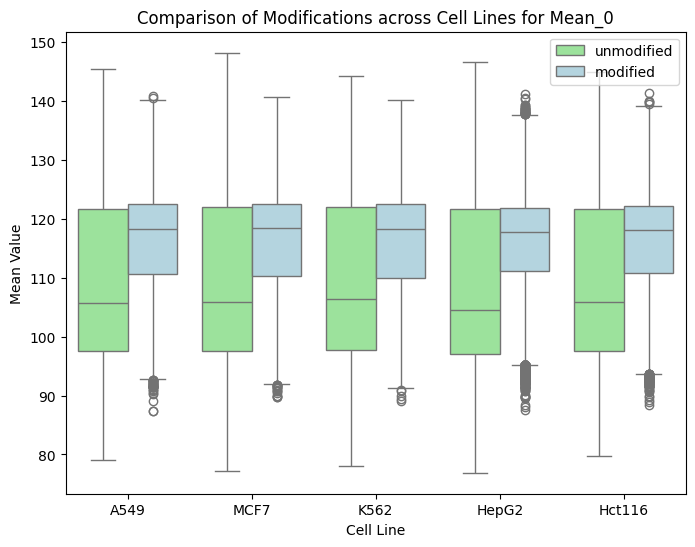

In [4]:
# plot graph C as following the slides [Distribution of m6A Modifications Across Cell Lines]
# same as sean
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

# Create the boxplot
plt.figure(figsize=(8, 6))
sns.boxplot(x='source', y='mean_0_mean', hue='status', data=df, palette=['lightgreen', 'lightblue'])

# Set labels and title
plt.title('Comparison of Modifications across Cell Lines for Mean_0')
plt.ylabel('Mean Value')
plt.legend(loc='upper right')
plt.xlabel('Cell Line')
# Show the plot
plt.show()



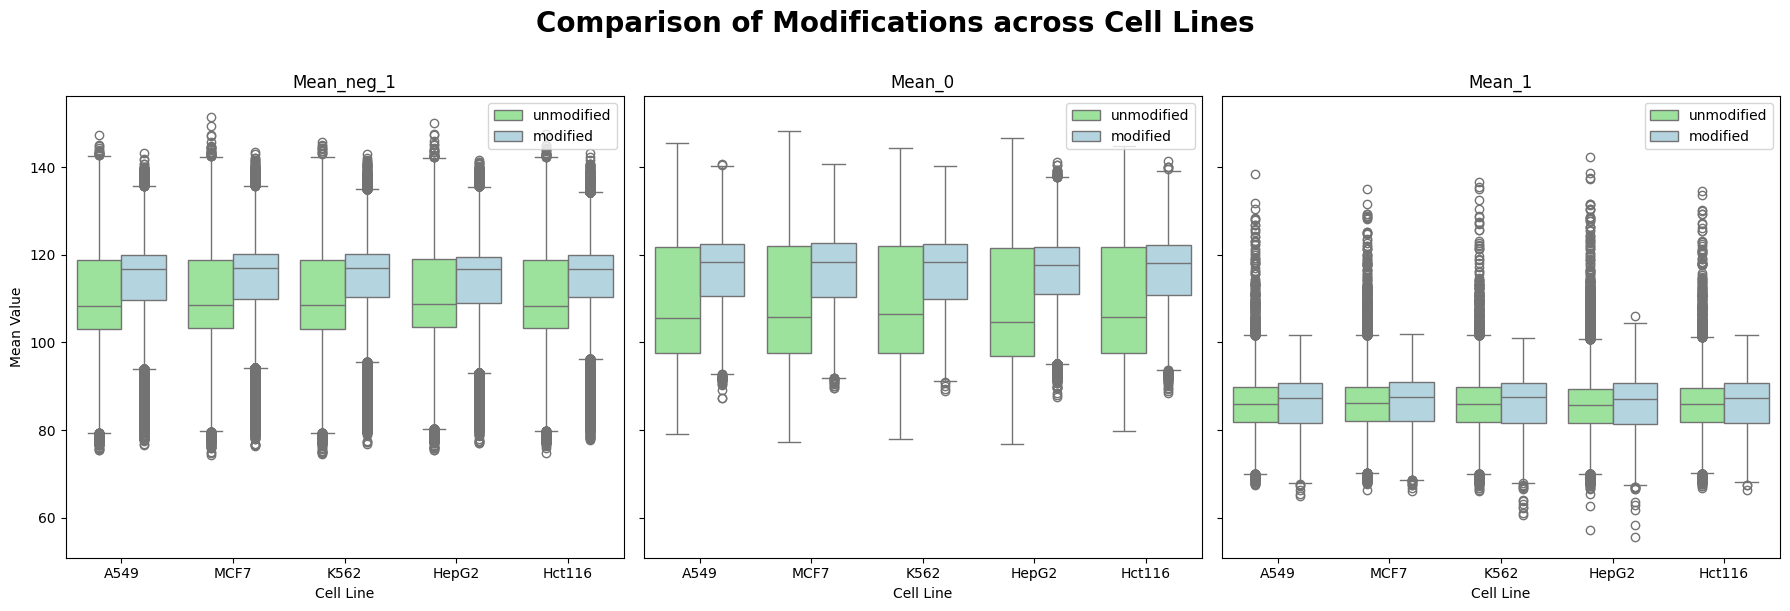

In [28]:
# comparison across modified/unmodified for means across cell lines
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

# Create a figure with 1 row and 3 columns
fig, axes = plt.subplots(1, 3, figsize=(18, 6), sharey=True)

# List of columns to plot
columns = ["mean_neg_1_mean", 'mean_0_mean', 'mean_1_mean']
titles = ['Mean_neg_1', 
          'Mean_0', 
          'Mean_1']

# Loop through each axis and column to create boxplots
for ax, col, title in zip(axes, columns, titles):
    sns.boxplot(x='source', y=col, hue='status', data=df, ax=ax, palette=['lightgreen', 'lightblue'])
    ax.set_title(title)
    ax.set_xlabel('Cell Line')
    ax.set_ylabel('Mean Value')
    ax.legend(loc='upper right')

plt.suptitle('Comparison of Modifications across Cell Lines', fontsize=20, fontweight='bold', y=1.01)
# Adjust layout
plt.tight_layout()

# Show the plot
plt.show()


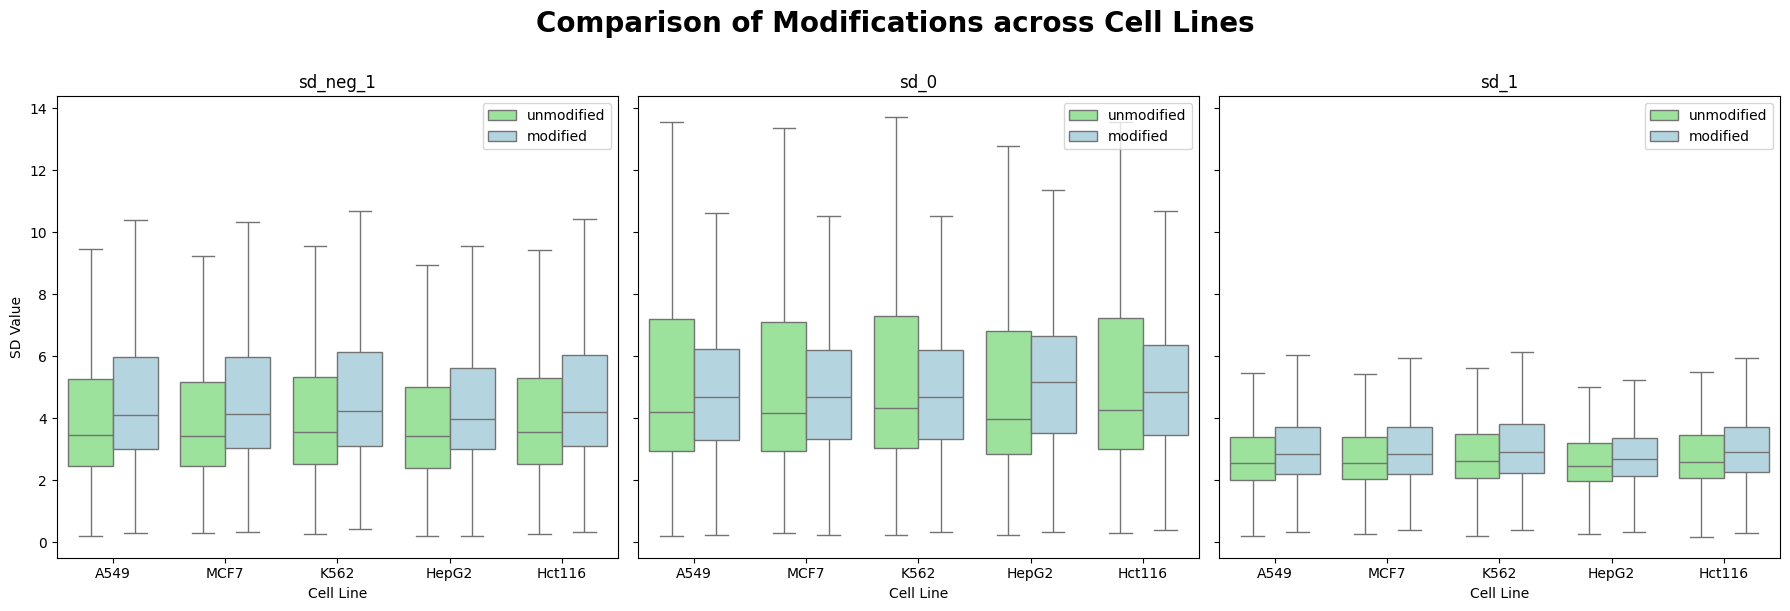

In [29]:
# comparison across modified/unmodified for sd across cell lines
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

# Create a figure with 1 row and 3 columns
fig, axes = plt.subplots(1, 3, figsize=(18, 6), sharey=True)

# List of columns to plot
columns = ["sd_neg_1_mean", 'sd_0_mean', 'sd_1_mean']
titles = ['sd_neg_1', 
          'sd_0', 
          'sd_1']

# Loop through each axis and column to create boxplots
for ax, col, title in zip(axes, columns, titles):
    sns.boxplot(x='source', y=col, hue='status', data=df, ax=ax, palette=['lightgreen', 'lightblue'], showfliers=False)
    ax.set_title(title)
    ax.set_xlabel('Cell Line')
    ax.set_ylabel('SD Value')
    ax.legend(loc='upper right')

plt.suptitle('Comparison of Modifications across Cell Lines', fontsize=20, fontweight='bold', y=1.01)

# Adjust layout
plt.tight_layout()

# Show the plot
plt.show()


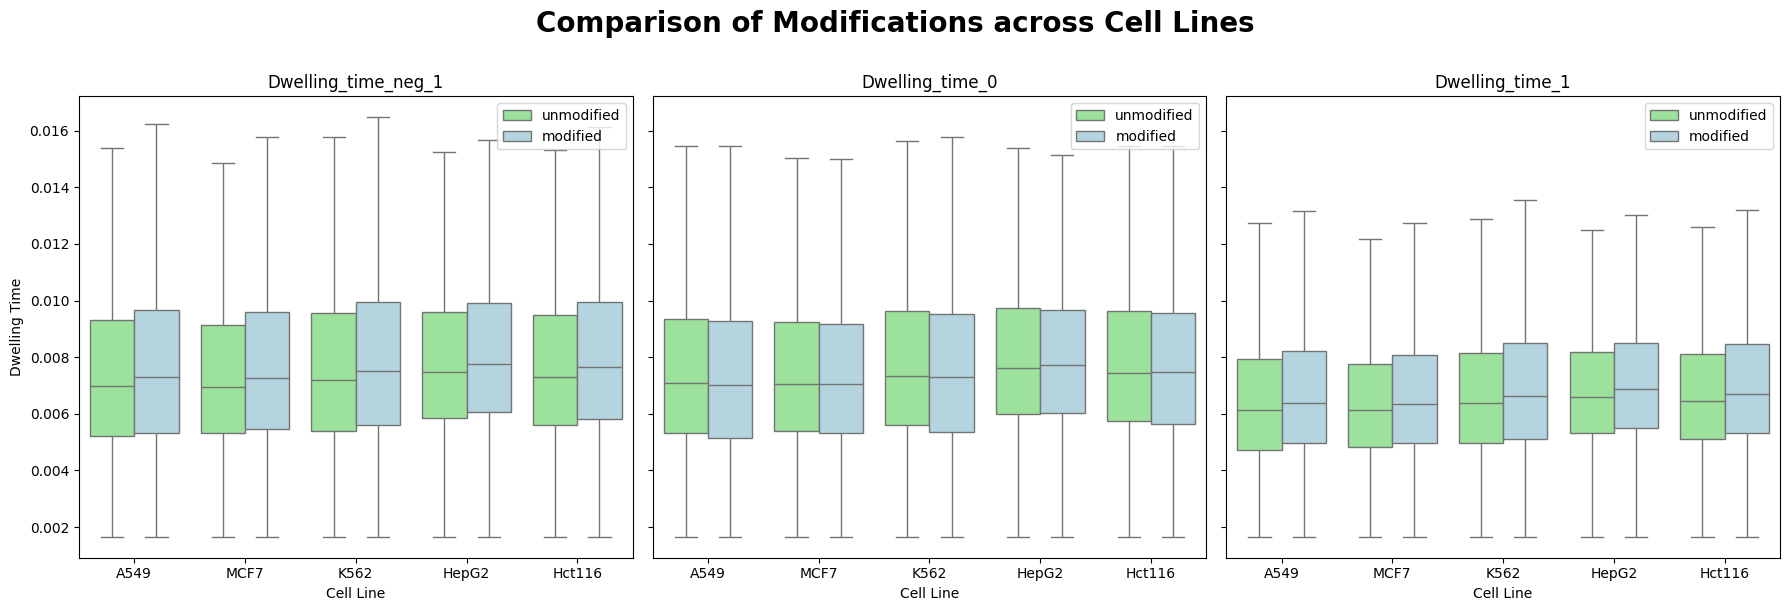

In [30]:
# comparison across modified/unmodified for dwelling time across cell lines
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

fig, axes = plt.subplots(1, 3, figsize=(18, 6), sharey=True)

# List of columns to plot
columns = ['dwelling_time_neg_1_mean', 'dwelling_time_0_mean', 'dwelling_time_1_mean']
titles = ['Dwelling_time_neg_1', 
          'Dwelling_time_0', 
          'Dwelling_time_1']

# Loop through each axis and column to create boxplots
for ax, col, title in zip(axes, columns, titles):
    sns.boxplot(x='source', y=col, hue='status', data=df, ax=ax, palette=['lightgreen', 'lightblue'], showfliers=False)
    ax.set_title(title)
    ax.set_xlabel('Cell Line')
    ax.set_ylabel('Dwelling Time')
    ax.legend(loc='upper right')

plt.suptitle('Comparison of Modifications across Cell Lines', fontsize=20, fontweight='bold', y=1.01)

# Adjust layout
plt.tight_layout()

# Show the plot
plt.show()


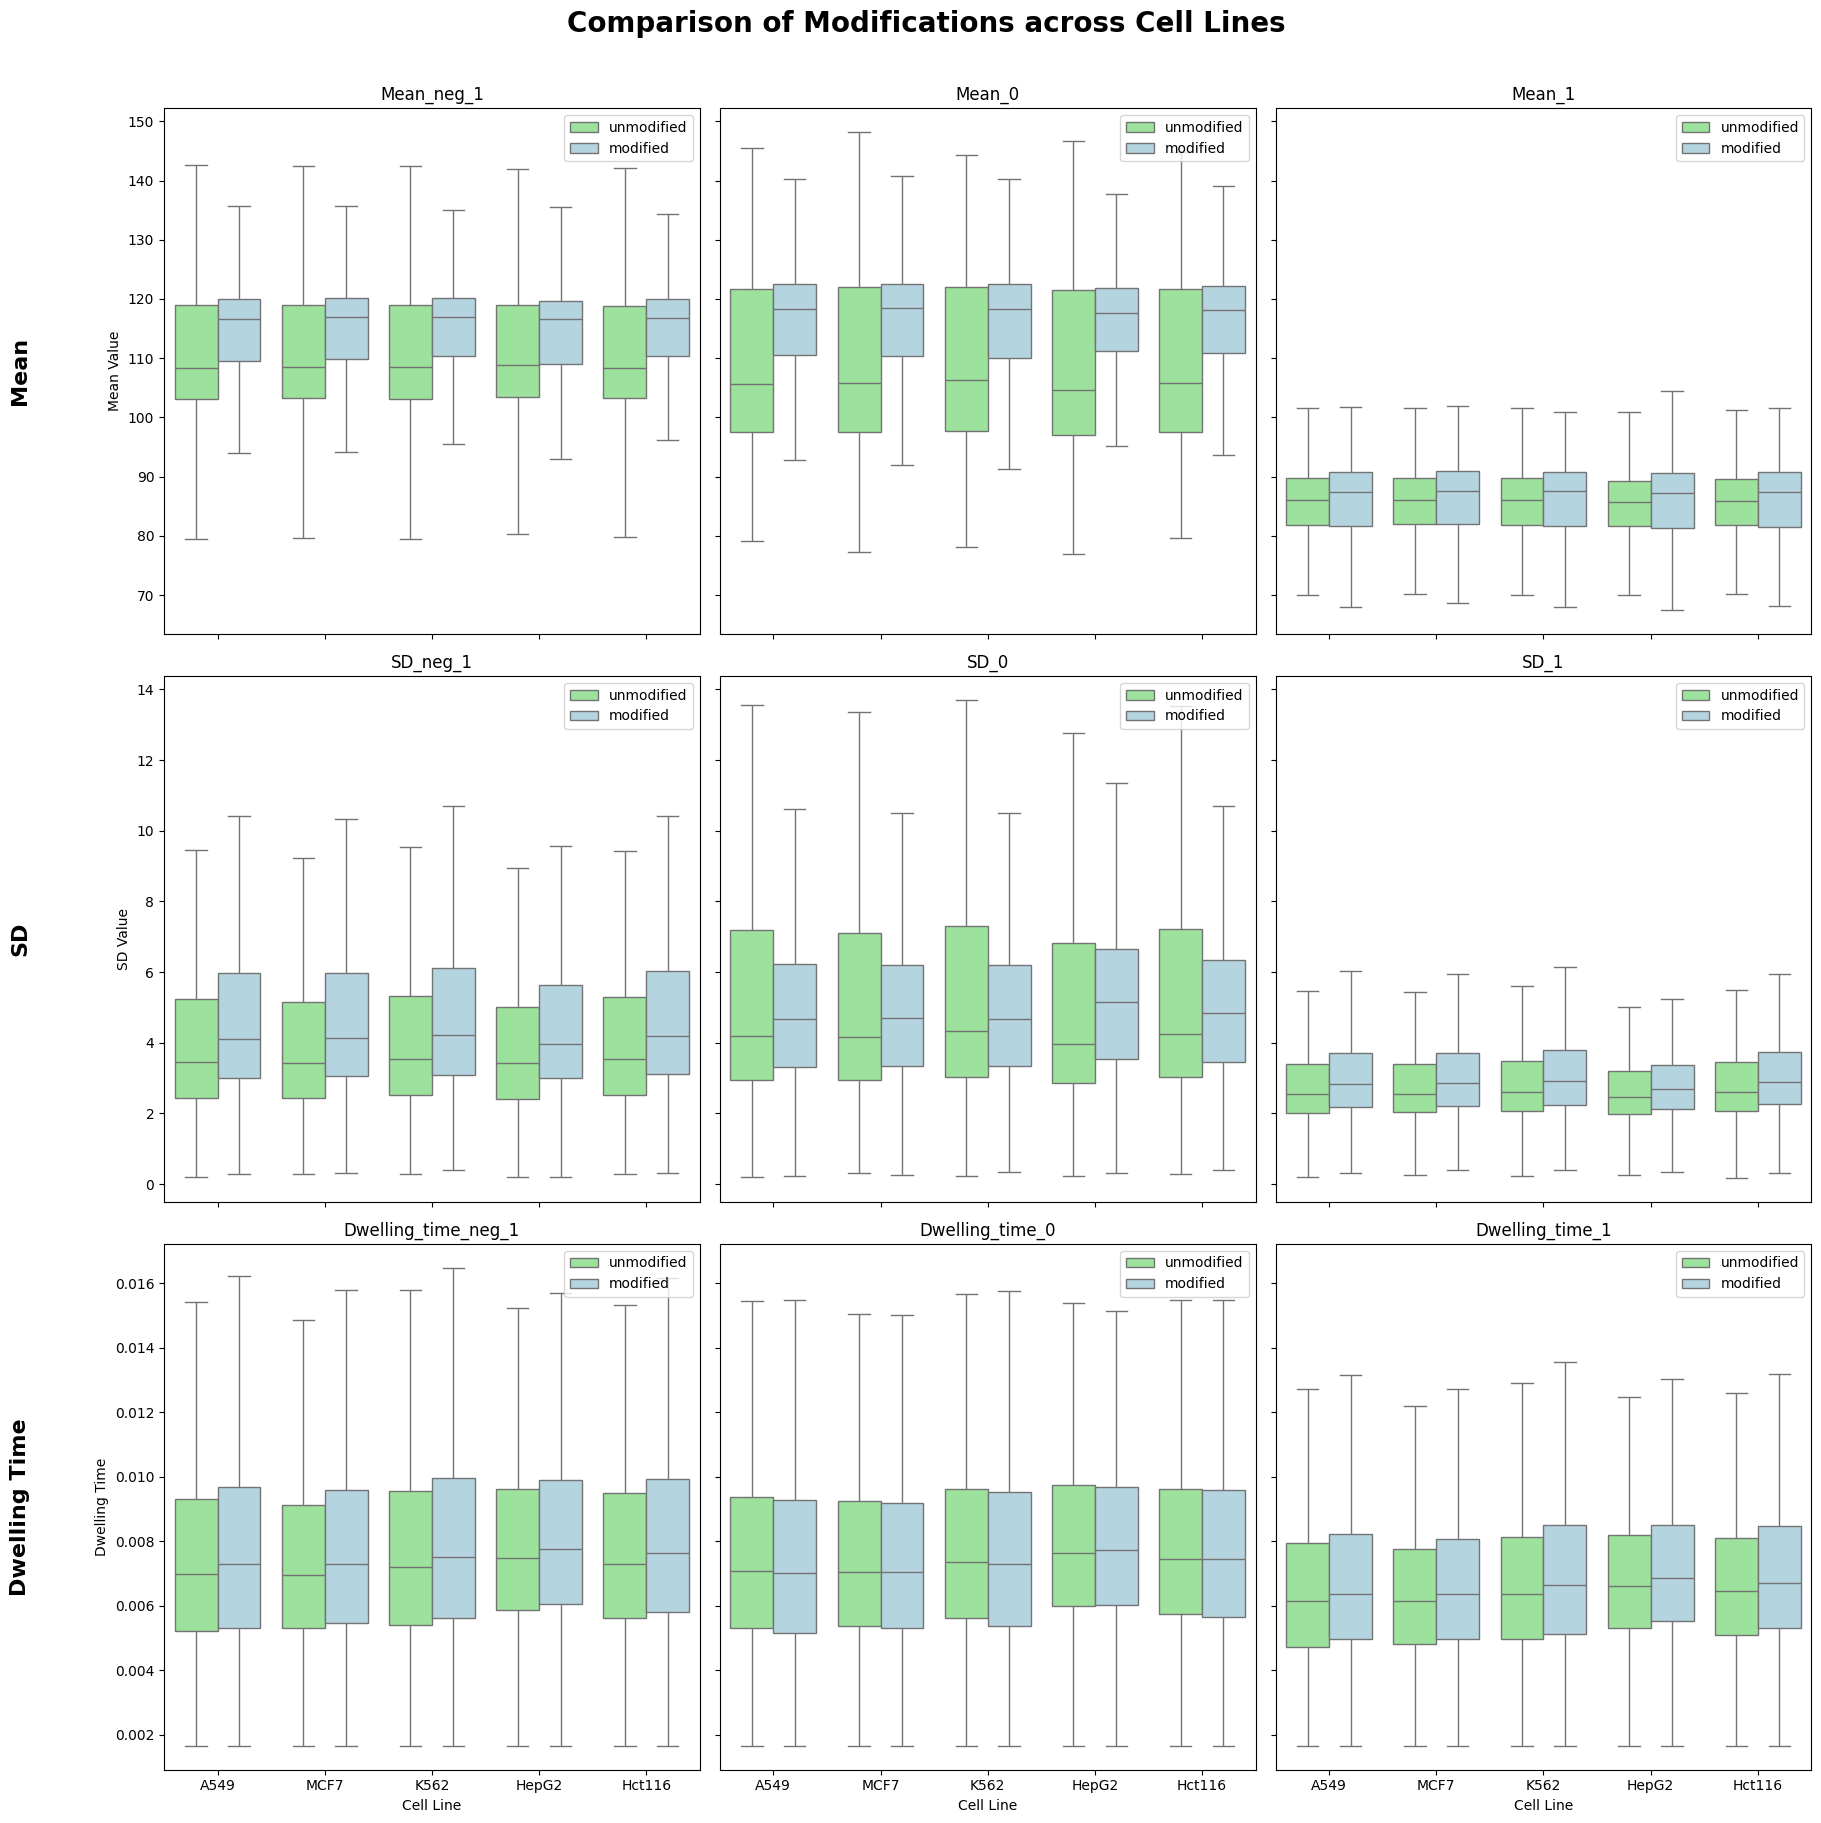

In [53]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

# Create a figure with 3 rows and 3 columns, sharing x and y axes
fig, axes = plt.subplots(3, 3, figsize=(18, 18), sharex='col', sharey='row')

# List of columns and titles for means, SD, and dwelling times
mean_columns = ["mean_neg_1_mean", 'mean_0_mean', 'mean_1_mean']
mean_titles = ['Mean_neg_1', 'Mean_0', 'Mean_1']

sd_columns = ["sd_neg_1_mean", 'sd_0_mean', 'sd_1_mean']
sd_titles = ['SD_neg_1', 'SD_0', 'SD_1']

dwelling_time_columns = ['dwelling_time_neg_1_mean', 'dwelling_time_0_mean', 'dwelling_time_1_mean']
dwelling_time_titles = ['Dwelling_time_neg_1', 'Dwelling_time_0', 'Dwelling_time_1']

# Function to create boxplots
def create_boxplot(ax, col, title, data, ylabel):
    sns.boxplot(x='source', y=col, hue='status', data=data, ax=ax, palette=['lightgreen', 'lightblue'], showfliers=False)
    ax.set_title(title)
    ax.set_xlabel('Cell Line')
    ax.set_ylabel(ylabel)
    ax.legend(loc='upper right')

# Loop through means
for ax, col, title in zip(axes[0], mean_columns, mean_titles):
    create_boxplot(ax, col, title, df, 'Mean Value')

# Loop through SDs
for ax, col, title in zip(axes[1], sd_columns, sd_titles):
    create_boxplot(ax, col, title, df, 'SD Value')

# Loop through dwelling times
for ax, col, title in zip(axes[2], dwelling_time_columns, dwelling_time_titles):
    create_boxplot(ax, col, title, df, 'Dwelling Time')

for i, label in enumerate(['Mean', 'SD', 'Dwelling Time']):
    axes[i][0].text(-0.25, 0.5, label, fontsize=16, fontweight='bold', va='center', ha='right',rotation=90, transform=axes[i][0].transAxes)

# Add a main title
plt.suptitle('Comparison of Modifications across Cell Lines', fontsize=20, fontweight='bold', y=1.01)

# Adjust layout
plt.tight_layout()

# Show the plot
plt.show()


/var/folders/r7/7xn5t9gj65x3tw58b7rmvtmm0000gn/T/ipykernel_843/3150543485.py:47: UserWarning: Tight layout not applied. tight_layout cannot make axes width small enough to accommodate all axes decorations
  plt.tight_layout(rect=[0.001, 0, 1, 0.95])  # Minimize the left margin


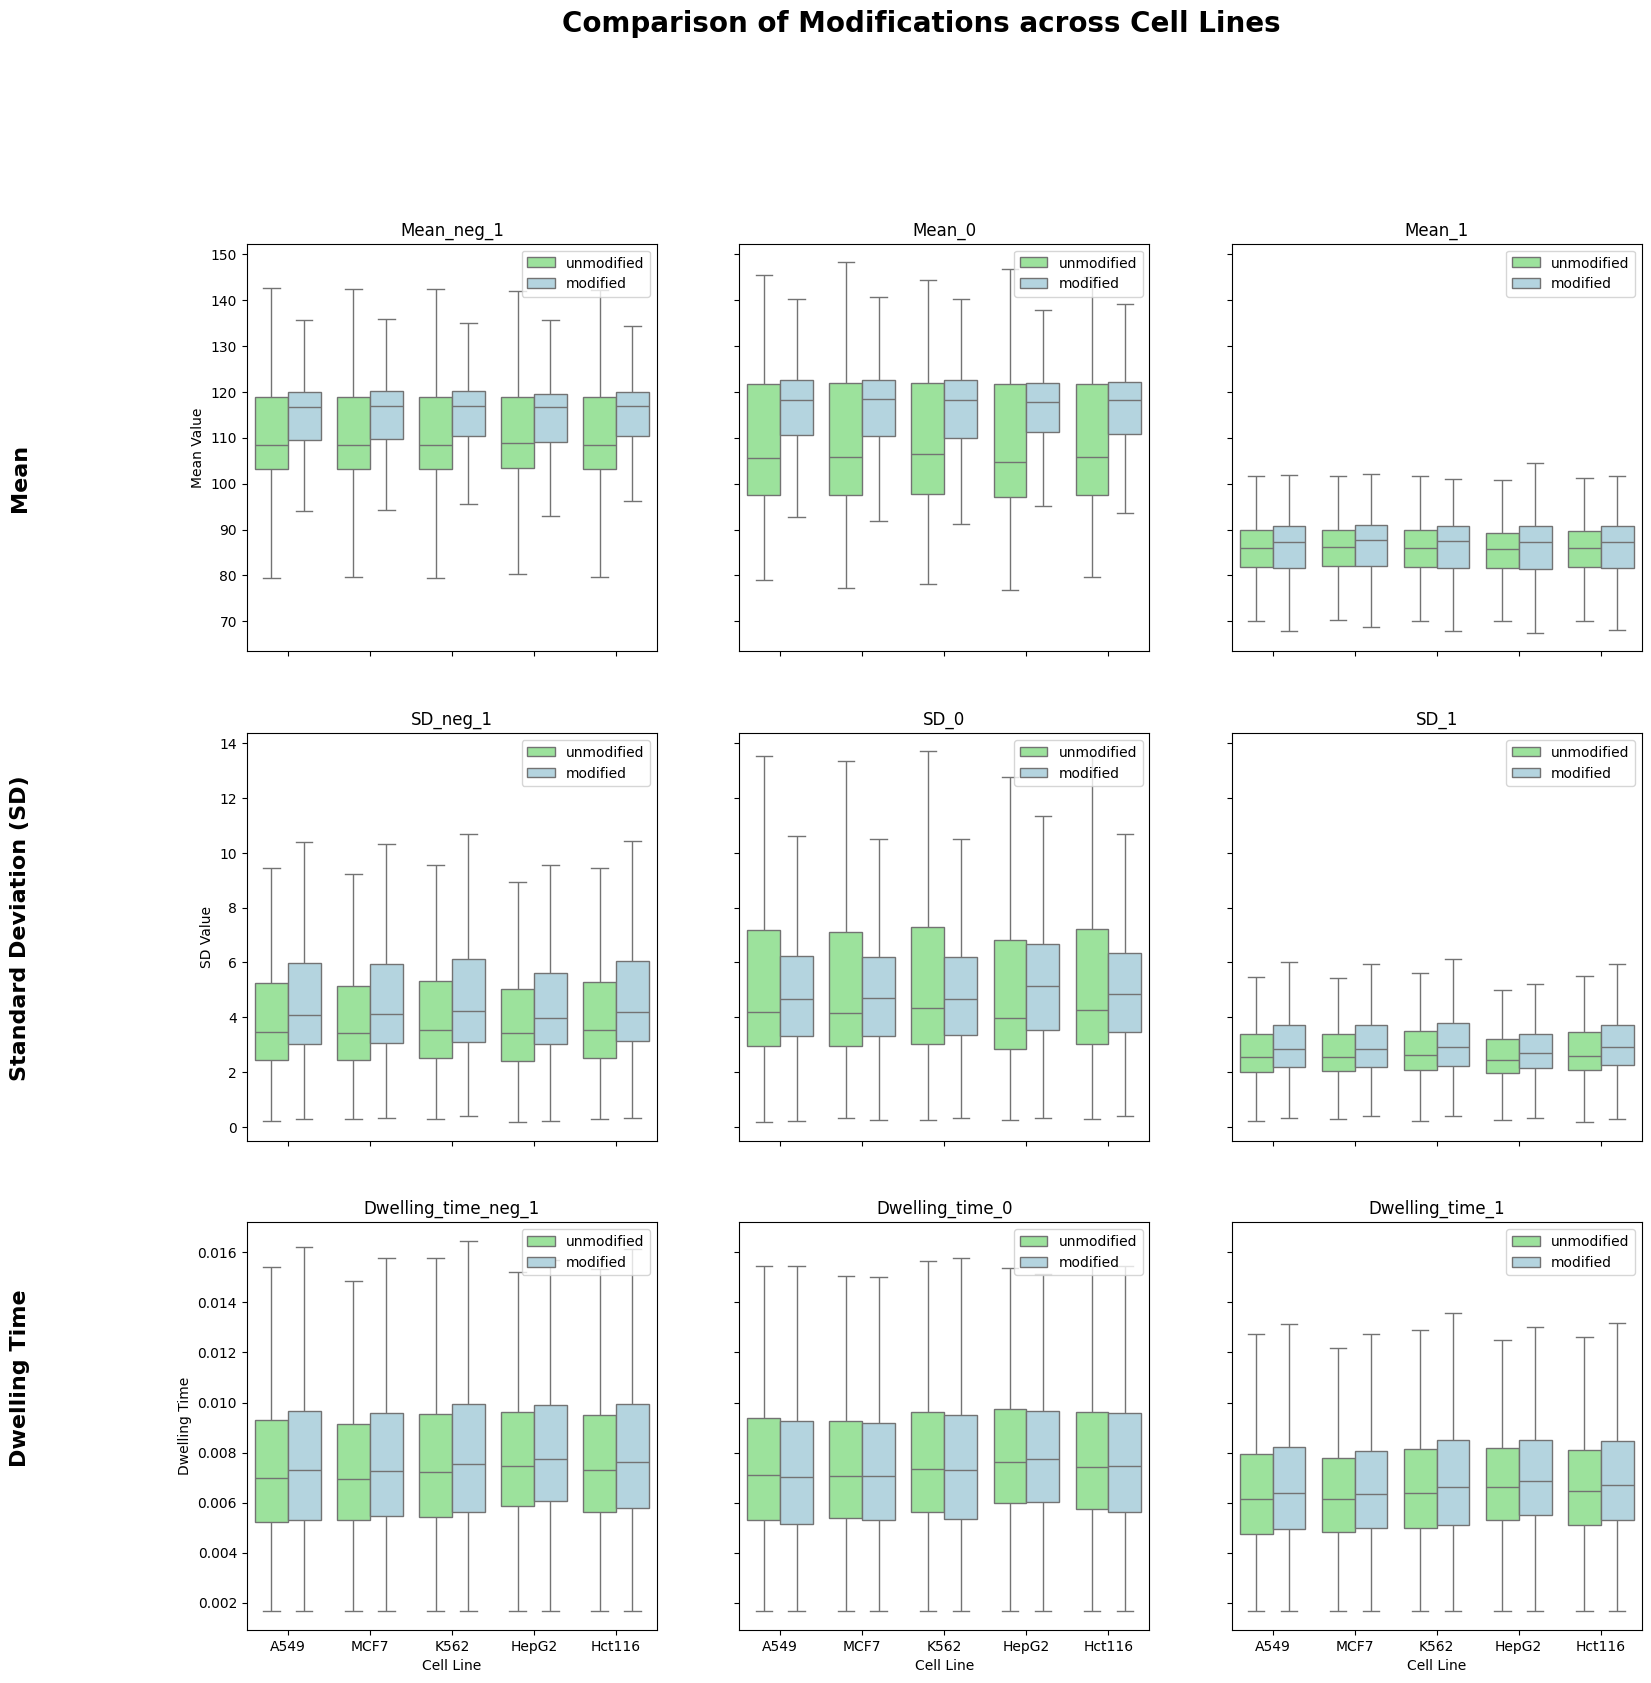

In [54]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

# Create a figure with 3 rows and 3 columns
fig, axes = plt.subplots(3, 3, figsize=(18, 18), sharex='col', sharey='row')

# List of columns and titles for means, SD, and dwelling times
mean_columns = ["mean_neg_1_mean", 'mean_0_mean', 'mean_1_mean']
mean_titles = ['Mean_neg_1', 'Mean_0', 'Mean_1']

sd_columns = ["sd_neg_1_mean", 'sd_0_mean', 'sd_1_mean']
sd_titles = ['SD_neg_1', 'SD_0', 'SD_1']

dwelling_time_columns = ['dwelling_time_neg_1_mean', 'dwelling_time_0_mean', 'dwelling_time_1_mean']
dwelling_time_titles = ['Dwelling_time_neg_1', 'Dwelling_time_0', 'Dwelling_time_1']

# Function to create boxplots
def create_boxplot(ax, col, title, data, ylabel):
    sns.boxplot(x='source', y=col, hue='status', data=data, ax=ax, palette=['lightgreen', 'lightblue'], showfliers=False)
    ax.set_title(title)
    ax.set_xlabel('Cell Line')
    ax.set_ylabel(ylabel)
    ax.legend(loc='upper right')

# Loop through means
for ax, col, title in zip(axes[0], mean_columns, mean_titles):
    create_boxplot(ax, col, title, df, 'Mean Value')

# Loop through SDs
for ax, col, title in zip(axes[1], sd_columns, sd_titles):
    create_boxplot(ax, col, title, df, 'SD Value')

# Loop through dwelling times
for ax, col, title in zip(axes[2], dwelling_time_columns, dwelling_time_titles):
    create_boxplot(ax, col, title, df, 'Dwelling Time')

# Add row headers, bringing them closer to the plots
plt.text(-0.001, 0.75, 'Mean', ha='center', va='center', fontsize=16, fontweight='bold', rotation=90, transform=fig.transFigure)
plt.text(-0.001, 0.5, 'Standard Deviation (SD)', ha='center', va='center', fontsize=16, fontweight='bold',rotation=90, transform=fig.transFigure)
plt.text(-0.001, 0.25, 'Dwelling Time', ha='center', va='center', fontsize=16, fontweight='bold', rotation=90, transform=fig.transFigure)

# Add a main title
plt.suptitle('Comparison of Modifications across Cell Lines', fontsize=20, fontweight='bold', y=1.01)

# Adjust layout with less padding on the left
plt.tight_layout(rect=[0.001, 0, 1, 0.95])  # Minimize the left margin

# Show the plot
plt.show()


Modified M6A genes display higher mean values

/var/folders/r7/7xn5t9gj65x3tw58b7rmvtmm0000gn/T/ipykernel_843/3383780165.py:8: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.violinplot(x='status', y='sd_0_mean', data=df, palette=['lightgreen', 'lightblue'], split=True)


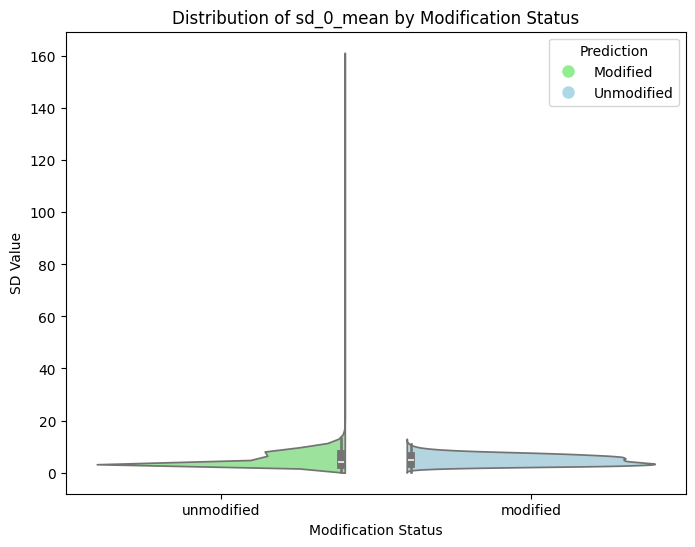

In [47]:
import seaborn as sns
import matplotlib.pyplot as plt

# Set the figure size for the plot
plt.figure(figsize=(8, 6))

# Create a violin plot for sd_0_mean, grouped by modification status
sns.violinplot(x='status', y='sd_0_mean', data=df, palette=['lightgreen', 'lightblue'], split=True)

# Add labels and title
plt.xlabel('Modification Status')
plt.ylabel('SD Value')
plt.title('Distribution of sd_0_mean by Modification Status')

# Create a custom legend
# We can create dummy handles for the legend
handles = [plt.Line2D([0], [0], marker='o', color='w', label='Modified', 
                       markerfacecolor='lightgreen', markersize=10),
           plt.Line2D([0], [0], marker='o', color='w', label='Unmodified', 
                       markerfacecolor='lightblue', markersize=10)]
plt.legend(handles=handles, title="Prediction", loc="upper right")

# Show the plot
plt.show()


/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/seaborn/axisgrid.py:718: UserWarning: Using the boxplot function without specifying `order` is likely to produce an incorrect plot.
  warnings.warn(warning)


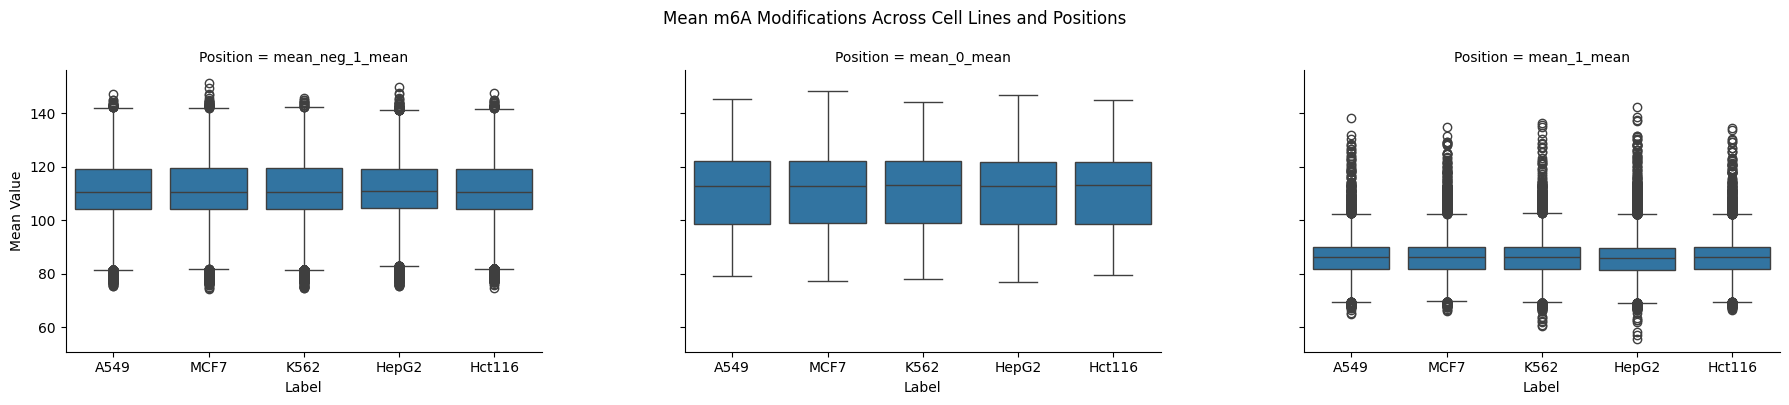

In [6]:
# comparison for mean value accross position and cell line
palette = {'unmodified': 'lightgreen', 'modified': 'lightblue'}

# Melt the DataFrame for plotting
df_melted = df.melt(id_vars=['source', 'status'], value_vars=['mean_neg_1_mean', 'mean_0_mean', 'mean_1_mean'],
                    var_name='Position', value_name='mean_value')

# Create a FacetGrid for the boxplots (single row)
g = sns.FacetGrid(df_melted, col='Position', margin_titles=True, height=4, aspect=1.5)
g.map(sns.boxplot, 'source', 'mean_value')

# Add title and adjust position
g.fig.suptitle('Mean m6A Modifications Across Cell Lines and Positions', y=1.00)  # Position the title higher
g.set_axis_labels('Label', 'Mean Value')  # Set axis labels

# Adjust the layout to prevent overlap with larger gaps
g.fig.subplots_adjust(top=0.85, hspace=0.8, wspace=0.3)
plt.show()


/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/seaborn/axisgrid.py:718: UserWarning: Using the boxplot function without specifying `order` is likely to produce an incorrect plot.
  warnings.warn(warning)


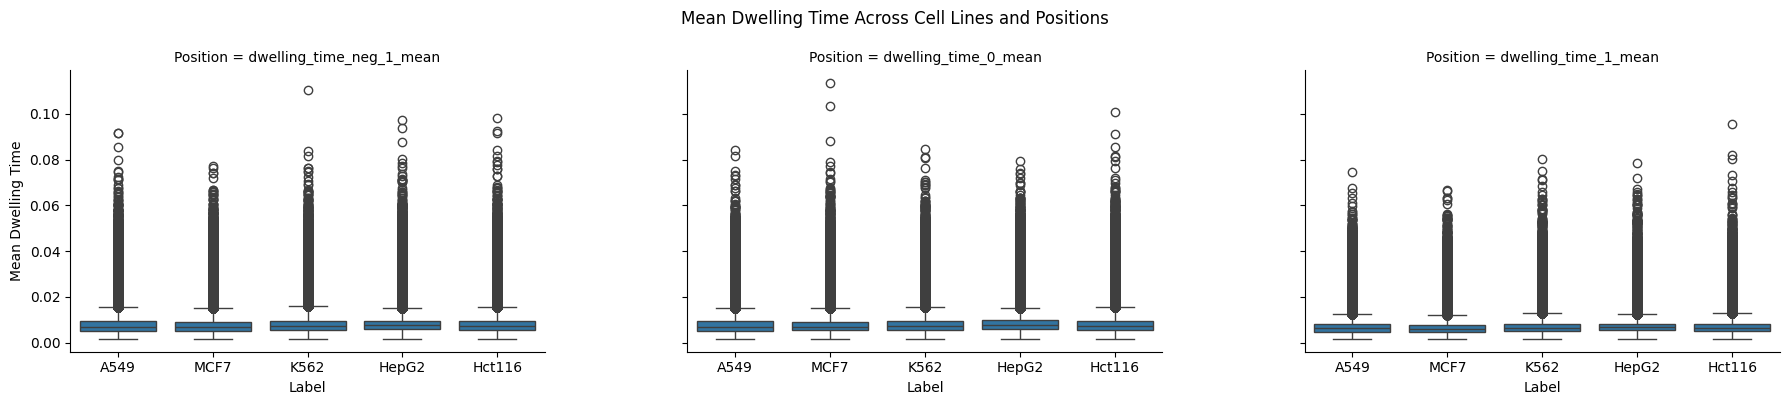

In [12]:
# comparison for dwelling time accross position and cell line

palette = {'unmodified': 'lightgreen', 'modified': 'lightblue'}

# Melt the DataFrame for plotting
df_melted = df.melt(id_vars=['source', 'status'], 
                    value_vars=['dwelling_time_neg_1_mean', 'dwelling_time_0_mean', 'dwelling_time_1_mean'],
                    var_name='Position', value_name='mean_dwelling_time')

# Create a FacetGrid for the boxplots (single row)
g = sns.FacetGrid(df_melted, col='Position', margin_titles=True, height=4, aspect=1.5)
g.map(sns.boxplot, 'source', 'mean_dwelling_time', showfliers=False, palette=palette)

# Add title and adjust position
g.fig.suptitle('Mean Dwelling Time Across Cell Lines and Positions', y=1.00)  # Position the title higher
g.set_axis_labels('Cell Line', 'Mean Dwelling Time')  # Set axis labels

# Adjust the layout to prevent overlap with larger gaps
g.fig.subplots_adjust(top=0.85, hspace=0.8, wspace=0.3)
plt.show()

